In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [3]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [4]:
from numba import njit
%config Completer.use_jedi = False

In [5]:
def logit(p):
    return np.log(p/(1-p))

## Test sample

In [6]:
import sys, h5py, numpy as np, scipy.stats, healpy as hp, tqdm
from SelectionFunctionChisel import Chisel

In [7]:
eps=1e-10

M_bins = np.arange(5,22.1,1)
M = len(M_bins)-1
C = 1
nside=4
jmax=2
B=2.

lengthscale_m = 3.
lengthscale_c = 1.

file_root = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_lm{lengthscale_m}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

nside_original = 128
resize = int((nside_original/nside)**2+0.1)

In [8]:
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = hf['n'][...]
    box['k'] = hf['k'][...]
    M_bins = hf['magbins'][...]
print("Mag bins:", np.linspace(M_bins[0], M_bins[-1], M+1))

Mag bins: [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.]


# Load in model

In [9]:
from SelectionFunctionPython import pyChisel

In [10]:
# Import chisel
pychisel = pyChisel(box['k'].copy(), box['n'].copy(),
                basis_options, file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                Mlim = [M_bins[0], M_bins[-1]],
                Clim = [-100,100],
                sigma = [-0.81489922, -2.55429039],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/StanOutput/'
                )

pychisel.M_subspace

Spherical basis file loaded
17 11
1 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


32.09% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


11

In [18]:
z0 = np.random.rand(pychisel.S, pychisel.M_subspace, pychisel.C_subspace)-0.5
#z0 = np.zeros((pychisel.S, pychisel.M_subspace, pychisel.C_subspace))

res = pychisel.minimize(z0, method='Newton-CG', \
                          options={'disp':True, 'maxiter':50, 'xtol':1e-4})

t=00000, lnL=-861745568, gnorm=257391542
t=00000, lnL=-630071156, gnorm=52009578
t=00003, lnL=-555054675, gnorm=20107934
t=00005, lnL=-541619563, gnorm=9221971
t=00007, lnL=-537235916, gnorm=4750077
t=00011, lnL=-530844961, gnorm=3022995
t=00014, lnL=-527305335, gnorm=2143964
t=00016, lnL=-527175461, gnorm=1011910
t=00039, lnL=-526006609, gnorm=828417
t=00074, lnL=-524185755, gnorm=725481
t=00082, lnL=-523768823, gnorm=646314
t=00084, lnL=-523704817, gnorm=343205
t=00150, lnL=-523166651, gnorm=271858
t=00241, lnL=-522644807, gnorm=516820
t=00242, lnL=-522643903, gnorm=166105
Optimization terminated successfully.
         Current function value: 522643903.000684
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 1833
         Hessian evaluations: 0
Optimum values stored in /data/asfe2/Projects/astrometry/StanOutput/chisquare_jmax2_nside4_M17_C1_lm3.0_scipy_results.h5


In [30]:
pychisel.stan_input

{'k': array([[[     21,      17,      20, ...,      27,      21,      28]],
 
        [[     87,      66,      51, ...,      68,      85,      72]],
 
        [[    219,     169,     162, ...,     216,     252,     187]],
 
        ...,
 
        [[ 789958,  257517,  229804, ..., 1191571, 2886174,  625369]],
 
        [[ 921554,  313850,  272762, ..., 1376940, 3406425,  781830]],
 
        [[    424,     350,     146, ...,     333,    1060,     373]]],
       dtype=uint64),
 'n': array([[[     23,      18,      20, ...,      28,      22,      28]],
 
        [[     89,      66,      52, ...,      68,      87,      72]],
 
        [[    221,     170,     163, ...,     219,     254,     189]],
 
        ...,
 
        [[ 795564,  260322,  232511, ..., 1199169, 2904095,  629497]],
 
        [[1075624,  376932,  336980, ..., 1651908, 3994815,  913958]],
 
        [[ 148755,   93065,   70246, ...,  157248,  492894,  160425]]],
       dtype=uint64),
 'P': 192,
 'M': 17,
 'M_subspace': 11,
 '

In [34]:
pychisel.wavelet_args_ray[0][5]

array([  0,   1,   2, ..., 236, 244, 245], dtype=uint64)

In [26]:
z0 = np.random.rand(pychisel.S, pychisel.M_subspace, pychisel.C_subspace)-0.5
#z0 = np.zeros((pychisel.S, pychisel.M_subspace, pychisel.C_subspace))

res = pychisel.minimize(z0, method='Newton-CG', \
                          options={'disp':True, 'maxiter':50, 'xtol':1e-4})

t=00005, lnL=-857830352, gnorm=258620848
t=00006, lnL=-628459912, gnorm=52101532
t=00009, lnL=-554461646, gnorm=19901745
t=00011, lnL=-540394609, gnorm=7245811


KeyboardInterrupt: 

In [72]:
z0 = np.random.rand(pychisel.S, pychisel.M_subspace, pychisel.C_subspace)-0.5
#z0 = np.zeros((pychisel.S, pychisel.M_subspace, pychisel.C_subspace))

res = pychisel.minimize_ray(z0, method='Newton-CG', ncores=3,\
                          options={'disp':True, 'maxiter':50, 'xtol':1e-4})

Initialising arguments.
P sets:  [96 96] 192
Running optimizer.
t=00000, lnL=-843183081, gnorm=245952954
t=00000, lnL=-629006990, gnorm=55658585
t=00003, lnL=-550801075, gnorm=21618275
t=00004, lnL=-543753887, gnorm=10462459
t=00005, lnL=-536516159, gnorm=6097209
t=00008, lnL=-531563364, gnorm=4640542
t=00013, lnL=-529999901, gnorm=2330443
t=00021, lnL=-527576467, gnorm=1431243
t=00032, lnL=-524987150, gnorm=2265457
t=00032, lnL=-524977624, gnorm=852576
Optimization terminated successfully.
         Current function value: 524977624.407323
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 262
         Hessian evaluations: 0
Processing results.
Optimum values stored in /data/asfe2/Projects/astrometry/StanOutput/chisquare_jmax2_nside4_M17_C1_lm3.0_scipy_results.h5


In [11]:
z0 = np.random.rand(pychisel.S, pychisel.M_subspace, pychisel.C_subspace)-0.5
#z0 = np.zeros((pychisel.S, pychisel.M_subspace, pychisel.C_subspace))

res = pychisel.minimize_ray(z0, method='Newton-CG', ncores=3,\
                          options={'disp':True, 'maxiter':50, 'xtol':1e-4})

Initialising arguments.
P sets:  [96 96] 192
Initialising ray processes.


2021-04-01 15:31:47,871	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


Running optimizer.
(pid=29631) t=007, n=04, lnL=-810176503, gnorm=227012420 
(pid=29631) t=007, n=08, lnL=-626712834, gnorm=52624670 
(pid=29631) t=010, n=32, lnL=-553729624, gnorm=20540123 
(pid=29631) t=011, n=54, lnL=-537248843, gnorm=6294166 
(pid=29631) t=013, n=72, lnL=-533608981, gnorm=4171725 
(pid=29631) t=017, n=122, lnL=-528506642, gnorm=2623548 
(pid=29631) t=019, n=140, lnL=-528100332, gnorm=1341808 
(pid=29631) t=034, n=302, lnL=-527327152, gnorm=1166848 
(pid=29631) t=052, n=502, lnL=-525958358, gnorm=897954 
(pid=29631) t=074, n=734, lnL=-524101357, gnorm=825411 
(pid=29631) t=075, n=744, lnL=-524086916, gnorm=409495 
(pid=29631) t=100, n=1042, lnL=-523584956, gnorm=310480 
(pid=29631) t=121, n=1284, lnL=-523047345, gnorm=582343 
Optimization terminated successfully.
         Current function value: 523046525.255303
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 1288
         Hessian evaluations: 0
Processing results.
Optimum va

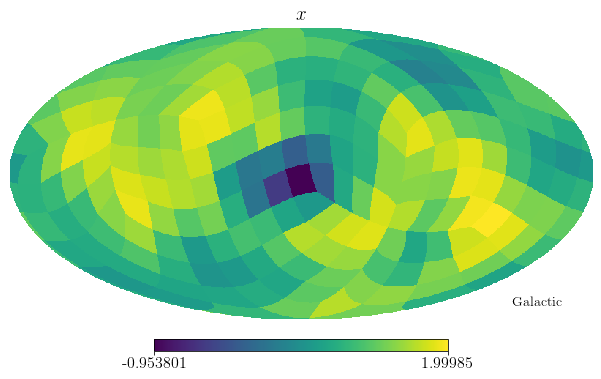

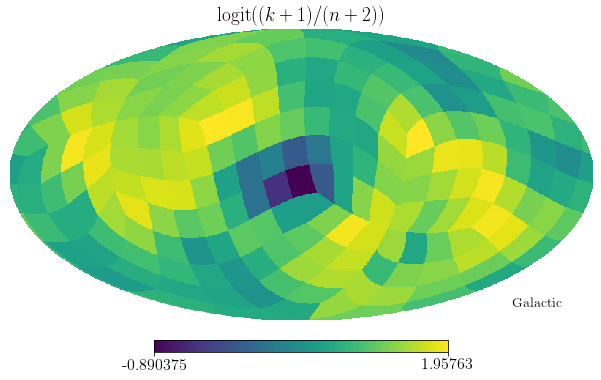

In [12]:
ii=15
hp.mollview(pychisel.optimum_x[15,0], nest=True, coord=['C','G'], title=r'$x$')

x_obs = logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2))
hp.mollview(x_obs, coord=['C','G'], title=r'$\mathrm{logit}((k+1)/(n+2))$')

# Testing x evaluation

In [188]:
sys.path.append("/home/andy/Documents/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/PythonModels/")
from wavelet_magnitude_colour_position import wavelet_x_sparse, wavelet_b_sparse, wavelet_magnitude_colour_position_sparse

In [170]:
M=17; C=1

M_subspace, cholesky_m = pychisel._construct_cholesky_matrix(M,3.)
C_subspace, cholesky_c = pychisel._construct_cholesky_matrix(C,3.)

cholesky_m_w, cholesky_m_v, cholesky_m_u = pychisel._sparsify(cholesky_m)[1:]
cholesky_c_w, cholesky_c_v, cholesky_c_u = pychisel._sparsify(cholesky_c)[1:]

17 11
1 1
32.09% sparsity
0.00% sparsity


In [183]:
wavelet_u = pychisel.stan_input['wavelet_u']-1
wavelet_v = pychisel.stan_input['wavelet_v']-1
wavelet_w = pychisel.stan_input['wavelet_w']

Y = scipy.sparse.csr_matrix((wavelet_w, wavelet_v, wavelet_u)).toarray()

In [184]:
z = np.random.rand(pychisel.S, M_subspace, C_subspace)-0.5
x = np.zeros((pychisel.P, M, C))
MC = np.zeros((M, C))
lnL_grad = np.zeros((pychisel.S, M_subspace, C_subspace))

In [185]:
x = wavelet_x_sparse(z, M, C, pychisel.P, \
          pychisel.stan_input['mu'], pychisel.stan_input['sigma'], \
            wavelet_u, wavelet_v, wavelet_w,
            cholesky_m_u, cholesky_m_v, cholesky_m_w,
            cholesky_c_u, cholesky_c_v, cholesky_c_w,
            x, MC)

In [189]:
b = wavelet_b_sparse(z, M, C, pychisel.S, \
          pychisel.stan_input['mu'], pychisel.stan_input['sigma'], \
            wavelet_u, wavelet_v, wavelet_w,
            cholesky_m_u, cholesky_m_v, cholesky_m_w,
            cholesky_c_u, cholesky_c_v, cholesky_c_w,
            b, MC)

In [190]:
b_arr = pychisel.stan_input['mu'][:,None,None] + \
    pychisel.stan_input['sigma'][:,None,None] * (cholesky_m @ z @ cholesky_c.T)

x_arr = np.moveaxis(Y @ np.moveaxis(b_arr, 0, 1), 1,0)

In [192]:
np.max(np.abs((x_arr - x)/x_arr)), np.max(np.abs((b_arr - b)/b_arr))

(6.0978481135573634e-05, 0.02503039402512433)

In [178]:
wavelet_magnitude_colour_position_sparse(z, M, C, pychisel.P, \
                                         pychisel.k, pychisel.n, \
          pychisel.stan_input['mu'], pychisel.stan_input['sigma'], \
            wavelet_u, wavelet_v, wavelet_w,
            cholesky_m_u, cholesky_m_v, cholesky_m_w,
            cholesky_c_u, cholesky_c_v, cholesky_c_w,
            x, lnL_grad, MC)

(-1.0790745045986047e+22,
 array([[[ 5.30530334e+07],
         [ 8.77620832e+07],
         [ 1.09064193e+08],
         ...,
         [ 1.94606062e+06],
         [ 2.02768944e+05],
         [ 1.28917197e+05]],
 
        [[-7.44330947e+04],
         [-1.20349369e+05],
         [-1.24567756e+05],
         ...,
         [-4.41966287e+03],
         [-3.83866849e+02],
         [-3.56970919e+02]],
 
        [[-1.16382779e+04],
         [-1.20664453e+05],
         [ 4.74722036e+04],
         ...,
         [-2.91686430e+03],
         [-6.50850427e+02],
         [-3.53106520e+01]],
 
        ...,
 
        [[ 2.86657965e+04],
         [ 2.85930883e+04],
         [ 2.52193226e+04],
         ...,
         [ 8.24230744e+01],
         [-1.12791410e+02],
         [ 1.63905643e+02]],
 
        [[ 2.63588015e+04],
         [ 2.12440354e+04],
         [ 2.14736106e+04],
         ...,
         [-3.59692374e+02],
         [-3.19122870e+02],
         [ 2.44084035e+02]],
 
        [[-2.63895753e+04],
      

In [125]:
with h5py.File('/data/asfe2/Projects/astrometry/StanOutput/chisquare_jmax3_nside32_M17_C1_l0.3_results.h5', 'r') as hf:
        z_fit = hf['z'][...]

In [143]:
x_fit = wavelet_x(z_fit, M, C, pychisel.P, \
          pychisel.stan_input['mu'], pychisel.stan_input['sigma'], \
            wavelet_u, wavelet_v, wavelet_w,
            cholesky_m_u, cholesky_m_v, cholesky_m_w,
            cholesky_c_u, cholesky_c_v, cholesky_c_w,
            x, MC)

In [145]:
b = pychisel.stan_input['mu'][:,None,None] + \
    pychisel.stan_input['sigma'][:,None,None] * (cholesky_m @ z_fit @ cholesky_c.T)

x_fit = np.moveaxis(Y @ np.moveaxis(b, 0, 1), 1,0)

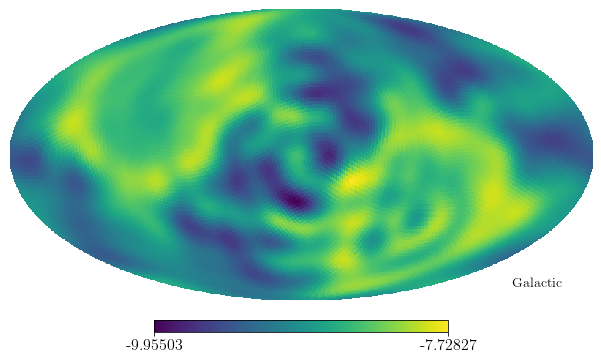

In [146]:
ii=15
hp.mollview(x_fit[:,ii,0], nest=False, coord=['C','G'], title='')

## Plot beast results

In [40]:
with h5py.File('/data/asfe2/Projects/astrometry/StanOutput/chisquare_jmax3_nside32_M17_C1_l0.3_B2.0_scipy_results.h5', 'r') as hf:
        x_fit = hf['x'][...]
        z_fit = hf['z'][...]
        b_fit = hf['b'][...]

In [41]:
z_fit.shape

(1021, 17, 1)

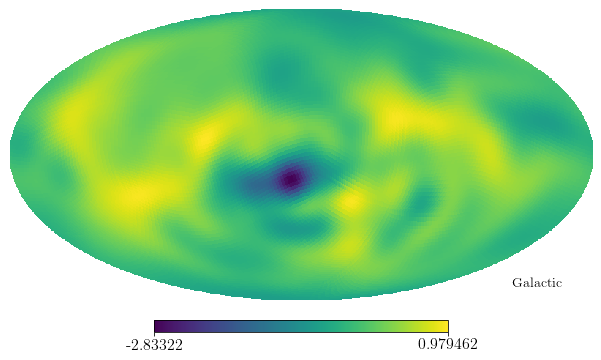

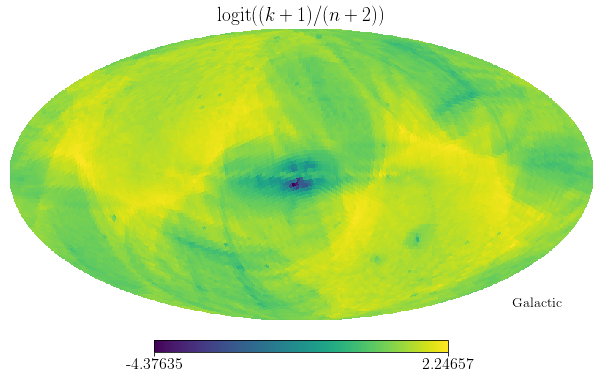

In [27]:
ii=15

x_obs = logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2))

hp.mollview(x_fit[ii,0], nest=True, coord=['C','G'], title='')#, min=np.min(x_obs), max=np.max(x_obs))

hp.mollview(x_obs, coord=['C','G'], 
            title=r'$\mathrm{logit}((k+1)/(n+2))$')

In [42]:
with h5py.File('/data/asfe2/Projects/astrometry/StanOutput/chisquare_jmax3_nside32_M17_C1_l0.3_results.h5', 'r') as hf:
        x_fit = hf['x'][...]
        z_fit = hf['z'][...]
        b_fit = hf['b'][...]

In [43]:
z_fit.shape

(1021, 11, 1)

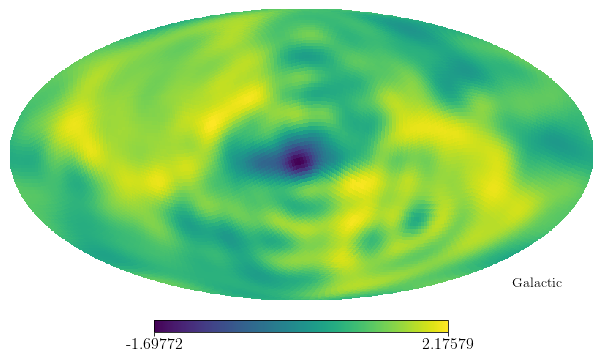

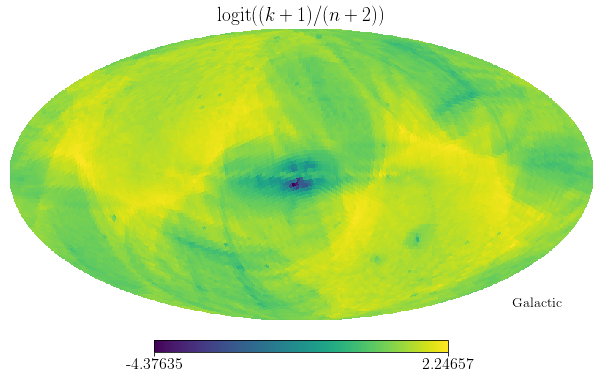

In [30]:
ii=15

x_obs = logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2))

hp.mollview(x_fit[ii,0], nest=True, coord=['C','G'], title='')#, min=np.min(x_obs), max=np.max(x_obs))

hp.mollview(x_obs, coord=['C','G'], 
            title=r'$\mathrm{logit}((k+1)/(n+2))$')

In [45]:
pychisel._generate_args()
%time pychisel.evaluate_likelihood(z_test)

CPU times: user 664 ms, sys: 4 ms, total: 668 ms
Wall time: 671 ms


(905910363.4588522,
 array([-1.13522174e+03, -1.08023759e+04, -7.98940615e+04, ...,
         9.10245750e+01,  2.45001976e+03,  1.92763910e+00]))

## Run model here

In [23]:
z0 = np.random.rand(pychisel.S, pychisel.M, pychisel.C)-0.5

bounds=np.zeros((len(z0.flatten()), 2))
bounds[:,0]=-5
bounds[:,1]=5


%time res = pychisel.minimize(z0, method='Newton-CG', options={'disp':True, 'maxiter':50, 'xtol':1e-5})#'iprint':20, 'maxfun':500})
#%time res = pychisel.minimize(z0, method='BFGS', options={'disp':True, 'maxiter':50, 'gtol':1e3})#'iprint':20, 'maxfun':500})

t=00000, lnL=-727951456, gnorm=194866585
t=00000, lnL=-633154317, gnorm=72481761
t=00000, lnL=-607963550, gnorm=32042339
t=00003, lnL=-568596682, gnorm=20566398
t=00004, lnL=-544361592, gnorm=11936622
t=00005, lnL=-542598457, gnorm=6040802
t=00008, lnL=-539292037, gnorm=5436206
t=00013, lnL=-533737259, gnorm=4539529
t=00018, lnL=-527614251, gnorm=5234214
t=00018, lnL=-527469335, gnorm=2627696
t=00018, lnL=-527395919, gnorm=1467191
t=00027, lnL=-526695517, gnorm=1313543
t=00041, lnL=-525446922, gnorm=1093218
t=00053, lnL=-523798281, gnorm=1048388
t=00053, lnL=-523787834, gnorm=505710
t=00071, lnL=-523405051, gnorm=423160
t=00105, lnL=-522797336, gnorm=326916
t=00116, lnL=-522575393, gnorm=281278
t=00117, lnL=-522571959, gnorm=133599
t=00199, lnL=-522439191, gnorm=115698
t=00293, lnL=-522233066, gnorm=92527
t=00355, lnL=-522134459, gnorm=101548
t=00356, lnL=-522134377, gnorm=49350
t=00414, lnL=-522122724, gnorm=33102
t=00499, lnL=-522106044, gnorm=17505
t=00570, lnL=-522100806, gnorm=963

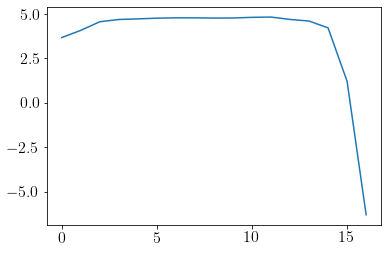

In [24]:
plt.plot(pychisel.optimum_b[0])

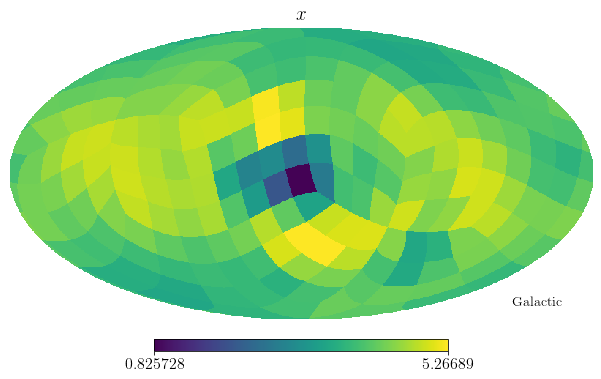

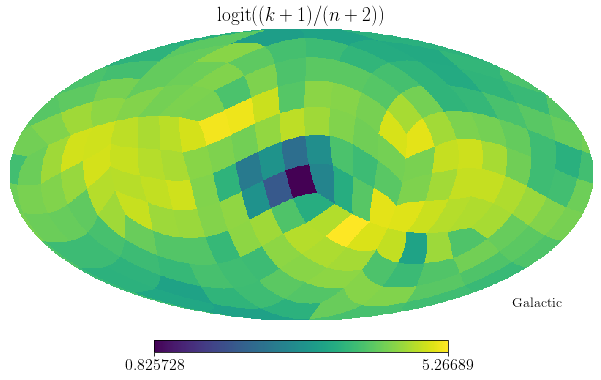

In [31]:
ii=14
minmax = np.min(logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2))),\
         np.max(logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2)))
hp.mollview(pychisel.optimum_x[ii,0], nest=True, coord=['C','G'], title=r'$x$',
           min=minmax[0], max=minmax[1])
hp.mollview(logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2)), coord=['C','G'], 
            title=r'$\mathrm{logit}((k+1)/(n+2))$', min=minmax[0], max=minmax[1])

# Test x evaluation

In [31]:
sys.path.append("/home/andy/Documents/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/PythonModels/")
from wavelet_magnitude_colour_position import wavelet_magnitude_colour_position, \
                                                wavelet_magnitude_colour_position_sparse, \
                                                get_wavelet_x2, get_wavelet_x1

In [32]:
pychisel._generate_args(sparse=True)
x_out = np.zeros((pychisel.P, pychisel.M, pychisel.C))
x_out = get_wavelet_x2(x_out, z_fit, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args[:-2])

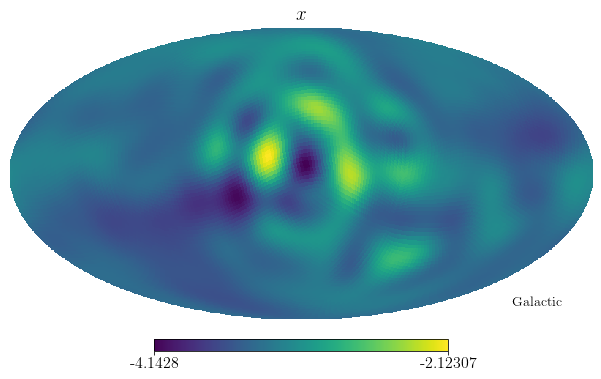

In [34]:
ii=15
hp.mollview(x_out[:,ii,0], nest coord=['C','G'], title=r'$x$')

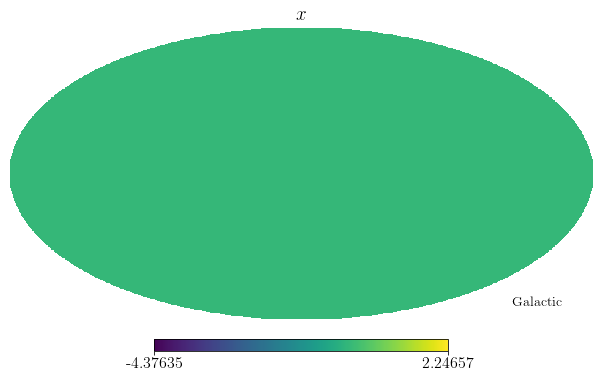

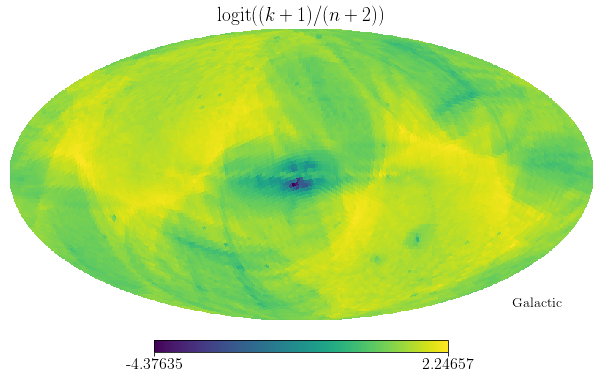

In [47]:
ii=15
minmax = np.min(logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2))),\
         np.max(logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2)))
hp.mollview(x_out[:,ii,0], nest=True, coord=['C','G'], title=r'$x$',
           min=minmax[0], max=minmax[1])
hp.mollview(logit((pychisel.k[ii,0]+1)/(pychisel.n[ii,0]+2)), coord=['C','G'], 
            title=r'$\mathrm{logit}((k+1)/(n+2))$', min=minmax[0], max=minmax[1])

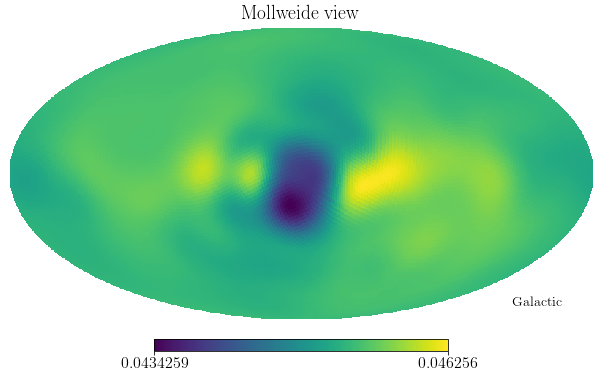

In [15]:
hp.mollview(x_out[:,15,0], coord=['C','G'])

In [36]:
x_out = np.zeros((pychisel.P, pychisel.M, pychisel.C))
pychisel._generate_args(sparse=False)
x_out = get_wavelet_x1(x_out, z_fit, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args[:-2])

ValueError: incompatible array sizes for np.dot(a, b) (matrix * matrix)

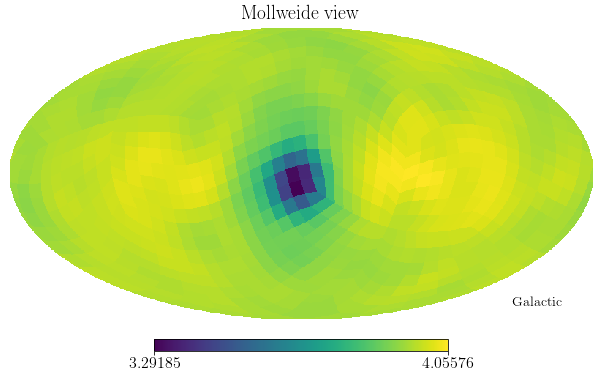

In [242]:
hp.mollview(x_out[:,15,0], coord=['C','G'])

In [244]:
x_out = np.zeros((pychisel.P, pychisel.M, pychisel.C))
pychisel._generate_args(sparse=True)
x_out = get_wavelet_x2(x_out, pychisel.optimum_z, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args[:-2])

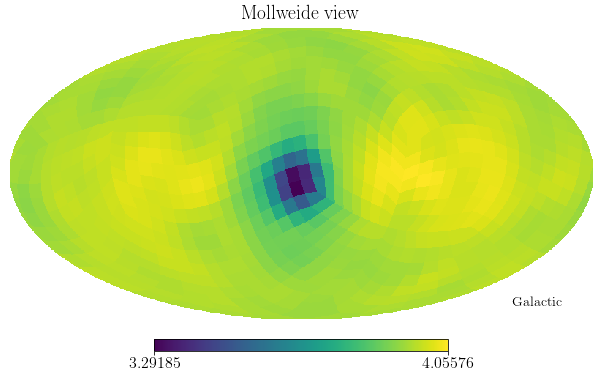

In [245]:
hp.mollview(x_out[:,15,0], coord=['C','G'])

## Parallel run

In [11]:
import ray
ray.init()

2021-03-30 15:13:04,008	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.168.26',
 'raylet_ip_address': '192.168.168.26',
 'redis_address': '192.168.168.26:6379',
 'object_store_address': '/tmp/ray/session_2021-03-30_15-13-03_422569_1654/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-30_15-13-03_422569_1654/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-30_15-13-03_422569_1654',
 'metrics_export_port': 51279,
 'node_id': '174c238d138c135a678a1c1f0a6378350b075e9dfb087006f25f6b30'}

In [6]:
@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures))

[0, 1, 4, 9]


In [7]:
import time

In [10]:
@ray.remote
def f(x):
    time.sleep(0.1)
    return x * x

In [11]:
futures = [f.remote(i) for i in range(400)]
print(ray.get(futures))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801, 10000, 10201, 10404, 10609, 10816, 11025, 11236, 11449, 11664, 11881, 12100, 12321, 12544, 12769, 12996, 13225, 13456, 13689, 13924, 14161, 14400, 14641, 14884, 15129, 15376, 15625, 15876, 16129, 16384, 16641, 16900, 17161, 17424, 17689, 17956, 18225, 18496, 18769, 19044, 19321, 19600, 19881, 20164, 20449, 20736, 21025, 21316, 21609, 21904, 22201, 22500, 22801, 23104, 23409, 23716, 24025, 24336, 24649, 24964, 25281, 25600, 25921, 26244, 2656

In [27]:
@ray.remote
class Counter(object):
    def __init__(self, n0):
        self.n = n0

    def increment(self):
        ni = 0
        while ni<1e7:
            self.n += 1
            ni+=1

    def read(self):
        return self.n, self.n+1

In [28]:
counters = [Counter.remote(5) for i in range(3)]

In [29]:
[c.increment.remote() for c in counters]

[ObjectRef(0c94a57c0ef0c2308dae4e8559497acf50d3b6d40100000001000000),
 ObjectRef(7f8daad1557c1075016750f70cca0b68d1734e150100000001000000),
 ObjectRef(27770fc93ff61bc2cd02104ee58680143b7ead090100000001000000)]

In [30]:
futures = [c.read.remote() for c in counters]
print(ray.get(futures))

[(10000005, 10000006), (10000005, 10000006), (10000005, 10000006)]


In [37]:
pychisel._generate_args()

In [40]:
pychisel.P

192

In [43]:
for ii in range(len(pychisel.wavelet_args)):
    print(pychisel.wavelet_args[ii].shape)

(192, 17, 1)
(192, 17, 1)
(253,)
(253,)
(193,)
(24320,)
(24320,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)


In [47]:
pychisel.stan_input['wavelet_u']

array([    1,   130,   259,   388,   517,   647,   777,   907,  1037,
        1167,  1297,  1427,  1557,  1682,  1809,  1934,  2059,  2186,
        2311,  2436,  2563,  2688,  2813,  2940,  3065,  3192,  3318,
        3444,  3571,  3698,  3824,  3950,  4077,  4204,  4330,  4456,
        4583,  4710,  4836,  4962,  5089,  5213,  5339,  5464,  5590,
        5714,  5840,  5965,  6091,  6215,  6341,  6466,  6592,  6716,
        6842,  6967,  7093,  7218,  7343,  7468,  7593,  7718,  7843,
        7968,  8093,  8218,  8343,  8468,  8593,  8718,  8843,  8968,
        9093,  9221,  9349,  9478,  9606,  9734,  9862,  9991, 10119,
       10247, 10375, 10504, 10632, 10760, 10888, 11017, 11145, 11272,
       11399, 11526, 11653, 11780, 11907, 12034, 12161, 12288, 12415,
       12542, 12669, 12796, 12923, 13050, 13177, 13305, 13433, 13562,
       13690, 13818, 13946, 14075, 14203, 14331, 14459, 14588, 14716,
       14844, 14972, 15101, 15229, 15354, 15479, 15604, 15729, 15854,
       15979, 16104,

In [15]:
pychisel._generate_args(sparse=True)

In [19]:
pychisel.wavelet_args[4]

array([    0,   129,   258,   387,   516,   646,   776,   906,  1036,
        1166,  1296,  1426,  1556,  1681,  1808,  1933,  2058,  2185,
        2310,  2435,  2562,  2687,  2812,  2939,  3064,  3191,  3317,
        3443,  3570,  3697,  3823,  3949,  4076,  4203,  4329,  4455,
        4582,  4709,  4835,  4961,  5088,  5212,  5338,  5463,  5589,
        5713,  5839,  5964,  6090,  6214,  6340,  6465,  6591,  6715,
        6841,  6966,  7092,  7217,  7342,  7467,  7592,  7717,  7842,
        7967,  8092,  8217,  8342,  8467,  8592,  8717,  8842,  8967,
        9092,  9220,  9348,  9477,  9605,  9733,  9861,  9990, 10118,
       10246, 10374, 10503, 10631, 10759, 10887, 11016, 11144, 11271,
       11398, 11525, 11652, 11779, 11906, 12033, 12160, 12287, 12414,
       12541, 12668, 12795, 12922, 13049, 13176, 13304, 13432, 13561,
       13689, 13817, 13945, 14074, 14202, 14330, 14458, 14587, 14715,
       14843, 14971, 15100, 15228, 15353, 15478, 15603, 15728, 15853,
       15978, 16103,

In [24]:
pychisel.wavelet_args_ray[0][4]

array([   0,  129,  258,  387,  516,  646,  776,  906, 1036, 1166, 1296,
       1426, 1556, 1681, 1808, 1933, 2058, 2185, 2310, 2435, 2562, 2687,
       2812, 2939, 3064, 3191, 3317, 3443, 3570, 3697, 3823, 3949, 4076,
       4203, 4329, 4455, 4582, 4709, 4835, 4961, 5088, 5212, 5338, 5463,
       5589, 5713, 5839, 5964, 6090, 6214, 6340, 6465, 6591, 6715, 6841,
       6966, 7092, 7217, 7342, 7467, 7592, 7717, 7842, 7967, 8092],
      dtype=uint64)

In [25]:
pychisel.wavelet_args_ray[1][4]

array([   0,  125,  250,  375,  500,  625,  750,  875, 1000, 1128, 1256,
       1385, 1513, 1641, 1769, 1898, 2026, 2154, 2282, 2411, 2539, 2667,
       2795, 2924, 3052, 3179, 3306, 3433, 3560, 3687, 3814, 3941, 4068,
       4195, 4322, 4449, 4576, 4703, 4830, 4957, 5084, 5212, 5340, 5469,
       5597, 5725, 5853, 5982, 6110, 6238, 6366, 6495, 6623, 6751, 6879,
       7008, 7136, 7261, 7386, 7511, 7636, 7761, 7886, 8011, 8136],
      dtype=uint64)

In [29]:
pychisel.wavelet_args_ray[1][5]

array([  0,   1,   2, ..., 246, 250, 251], dtype=uint64)

In [28]:
pychisel._generate_args_ray(nsets=3)

P sets:  [64 64 64] 192


In [65]:
for wavelet_set in pychisel.wavelet_args_ray:
    for ii in range(len(wavelet_set)):
        print(wavelet_set[ii].shape)

(64, 17, 1)
(64, 17, 1)
(253,)
(253,)
(64,)
(8092,)
(8092,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(64, 17, 1)
(64, 17, 1)
(253,)
(253,)
(64,)
(8136,)
(8136,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(64, 17, 1)
(64, 17, 1)
(253,)
(253,)
(64,)
(8092,)
(8092,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)


In [63]:
for wavelet_set in pychisel.wavelet_args_ray:
    for ii in range(len(wavelet_set)):
        print(wavelet_set[ii].shape)

(20, 17, 1)
(20, 17, 1)
(253,)
(253,)
(20,)
(2562,)
(2562,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(20, 17, 1)
(20, 17, 1)
(253,)
(253,)
(20,)
(2526,)
(2526,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2379,)
(2379,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2394,)
(2394,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2426,)
(2426,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2428,)
(2428,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2388,)
(2388,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2382,)
(2382,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2400,)
(2400,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)
(19, 17, 1)
(19, 17, 1)
(253,)
(253,)
(19,)
(2435,)
(2435,)
(17, 17)
(1, 1)
(253, 17, 1)
(17, 1)


In [11]:
import ray
ray.init()

2021-03-30 15:30:07,902	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.168.26',
 'raylet_ip_address': '192.168.168.26',
 'redis_address': '192.168.168.26:6379',
 'object_store_address': '/tmp/ray/session_2021-03-30_15-30-07_354299_4314/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-30_15-30-07_354299_4314/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-30_15-30-07_354299_4314',
 'metrics_export_port': 61400,
 'node_id': 'e2d1c233bd992fc7819919ba93798c8824170962e71c31ee6875ecaf'}

In [12]:
z0 = np.random.rand(pychisel.S, pychisel.M, pychisel.C)-0.5

%time res = pychisel.minimize_ray(z0, ncores=3, method='Newton-CG', \
                                  options={'disp':True, 'maxiter':50, 'xtol':1e-5})

P sets:  [96 96] 192


RayTaskError(TypeError): [36mray::combine.merge_likelihoods()[39m (pid=4440, ip=192.168.168.26)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 432, in ray._raylet.execute_task.function_executor
  File "/home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/SelectionFunctionPython.py", line 52, in merge_likelihoods
    lnL += e[0]
TypeError: 'NoneType' object is not subscriptable

## Test gradient

In [28]:
ii=10
grad = lambda z: pychisel.evaluate_likelihood(np.hstack((z, z_test.flatten()[ii:])))[1][:ii]
model = lambda z: pychisel.evaluate_likelihood(np.hstack((z, z_test.flatten()[ii:])))[0]

In [38]:
pychisel._generate_args(sparse=True)

In [51]:
sys.path.append("/home/andy/Documents/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/PythonModels/")
from wavelet_magnitude_colour_position import wavelet_magnitude_colour_position, \
                                                wavelet_magnitude_colour_position_sparse

ii=10
grad = lambda z: wavelet_magnitude_colour_position_sparse(np.hstack((z, z_test.flatten()[ii:])).reshape((pychisel.S, pychisel.M, pychisel.C)),
                                        pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)[1].flatten()[:ii]
model = lambda z: wavelet_magnitude_colour_position_sparse(np.hstack((z, z_test.flatten()[ii:])).reshape((pychisel.S, pychisel.M, pychisel.C)),
                                        pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)[0]

In [20]:
z_test = pychisel.optimum_z.copy()

In [17]:
scipy.optimize.approx_fprime(z_test.flatten()[:ii], model, 1e-6), grad(z_test.flatten()[:ii])

(array([ 2.65836716e+01,  1.19805336e+02,  5.23924828e+01, -1.37647986e+04,
         1.55336261e+04, -6.27515912e+04,  1.25952959e+04, -2.59152055e+04,
        -1.13552213e+04, -1.23786926e+03]),
 array([ 2.67060503e+01,  1.19752782e+02,  5.25646371e+01, -1.37645404e+04,
         1.55338531e+04, -6.27517675e+04,  1.25947551e+04, -2.59281825e+04,
        -1.13552046e+04, -1.23761740e+03]))

In [18]:
scipy.optimize.approx_fprime(z_test.flatten()[:ii], model, 1e-6), grad(z_test.flatten()[:ii])

(array([ 2.65836716e+01,  1.19805336e+02,  5.23924828e+01, -1.37647986e+04,
         1.55336261e+04, -6.27515912e+04,  1.25952959e+04, -2.59152055e+04,
        -1.13552213e+04, -1.23786926e+03]),
 array([ 2.67060503e+01,  1.19752782e+02,  5.25646371e+01, -1.37645404e+04,
         1.55338531e+04, -6.27517675e+04,  1.25947551e+04, -2.59281825e+04,
        -1.13552046e+04, -1.23761740e+03]))

In [56]:
scipy.optimize.approx_fprime(z_test.flatten()[:ii], model, 1e-4), grad(z_test.flatten()[:ii])

(array([-2.67064571e+01, -1.19766593e+02, -5.26863337e+01,  1.37631583e+04,
        -1.55365515e+04,  6.27338493e+04, -1.26791316e+04,  2.46326613e+04,
         1.13485450e+04,  1.23030543e+03]),
 array([-2.67060503e+01, -1.19752782e+02, -5.25646371e+01,  1.37645404e+04,
        -1.55338531e+04,  6.27517675e+04, -1.25947551e+04,  2.59281825e+04,
         1.13552046e+04,  1.23761740e+03]))

## Test x evaluation

In [31]:
Y = scipy.sparse.csr_matrix((pychisel.stan_input['wavelet_w'], pychisel.stan_input['wavelet_v']-1, pychisel.stan_input['wavelet_u']-1))
Cm = scipy.sparse.csr_matrix((pychisel.stan_input['cholesky_w_m'], pychisel.stan_input['cholesky_v_m']-1, pychisel.stan_input['cholesky_u_m']-1)).toarray()
Cc = scipy.sparse.csr_matrix((pychisel.stan_input['cholesky_w_c'], pychisel.stan_input['cholesky_v_c']-1, pychisel.stan_input['cholesky_u_c']-1)).toarray()

In [32]:
optimum_b = pychisel.stan_input['mu'][:,None,None] + pychisel.stan_input['sigma'][:,None,None] * (pychisel.cholesky_m @ pychisel.optimum_z @ pychisel.cholesky_c.T)

In [33]:
optimum_b = pychisel.stan_input['mu'][:,None,None] + pychisel.stan_input['sigma'][:,None,None] * (Cm @ pychisel.optimum_z @ Cc.T)

In [34]:
optimum_x = np.moveaxis(np.array([Y @ optimum_b[:,:,iC] for iC in range(pychisel.C)]), 0,2)

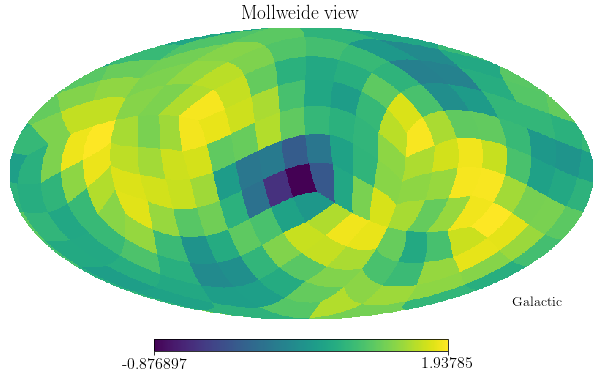

In [35]:
hp.mollview(optimum_x[:,15,0], coord=['C','G'])

In [278]:
opt_x_nest = pychisel._ring_to_nest(np.moveaxis(optimum_x, 0, -1))

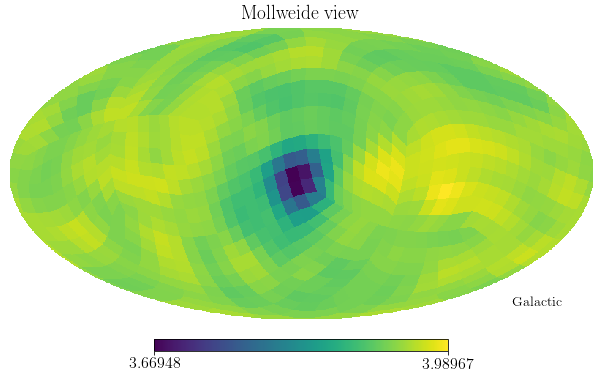

In [280]:
hp.mollview(opt_x_nest[15,0], nest=True, coord=['C','G'])

### Test cosh evaluation

In [47]:
k = 5; n=7
x = -0.1

In [48]:
lnL = k*x - n*np.log1p(np.exp(x))
lnL

-5.010776620514996

In [49]:
lnL = k*x - n*(x/2 + np.log(2*np.cosh(x/2)) )
lnL

-5.010776620514996

In [50]:
d = 1 + np.exp(-np.abs(x))
lnL = k*x - n*(x/2 + np.abs(x)/2 + np.log(d) )
lnL

-5.010776620514996

In [196]:
pychisel.optimum_z.shape

(253, 17, 1)

In [206]:
z_arr = np.moveaxis(pychisel.optimum_z, 0,1)

In [266]:
x_arr = Cm @ (Y @ pychisel.optimum_z[:,:,0]).T

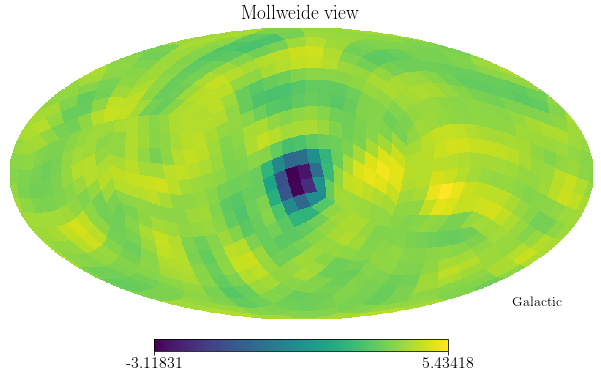

In [267]:
hp.mollview(x_arr[15], coord=['C','G'])

In [199]:
Y@np.moveaxis(pychisel.optimum_z, 0,2)

ValueError: could not interpret dimensions

In [194]:
Y.shape, Cm.shape, Cc.shape

((768, 253), (17, 17), (1, 1))

In [190]:
pychisel.P, pychisel.S

(768, 253)

# Sparse method

In [60]:
sys.path.append("/home/andy/Documents/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/PythonModels/")
from wavelet_magnitude_colour_position import wavelet_magnitude_colour_position, \
                                                wavelet_magnitude_colour_position_sparse, \
                                                get_wavelet_x2

In [18]:
z0 = np.zeros((pychisel.S, pychisel.M, pychisel.C))
z_test = z0 + 1

z_test = pychisel.optimum_z

In [19]:
pychisel._generate_args(sparse=False)
len(pychisel.wavelet_args)

11

In [20]:
%time ans = wavelet_magnitude_colour_position(z_test, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)
ans[0]

CPU times: user 5.55 s, sys: 20 ms, total: 5.57 s
Wall time: 5.8 s


-522790739.5039961

In [21]:
pychisel._generate_args(sparse=True)
len(pychisel.wavelet_args)

15

In [22]:
%time ans_sp = wavelet_magnitude_colour_position_sparse(z_test, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)
ans_sp[0]

[ 0.87589181  1.47701884  2.88004654  4.1722437   5.17557456  7.35780879
 18.87827585 20.22197084  5.82653032  5.53403419  4.81175575  5.32220695
  4.28678141  3.92824631  4.45080855  1.46649339 -6.36085053]
CPU times: user 3.48 s, sys: 24 ms, total: 3.5 s
Wall time: 3.54 s


-522790739.503996

In [ ]:
%time ans_sp = wavelet_magnitude_colour_position_sparse(z_test, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)
ans_sp[0]

In [41]:
from wavelet_magnitude_colour_position import wavelet_magnitude_colour_position_sparse

In [44]:
%time ans_sp = wavelet_magnitude_colour_position_sparse(z_test, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)
ans_sp[0]

CPU times: user 332 ms, sys: 0 ns, total: 332 ms
Wall time: 331 ms


-522790739.503996

In [160]:
ii=10
def foo(z):
    return 
    
grad = lambda z: pychisel.evaluate_likelihood(np.hstack((z, z_test.flatten()[ii:])))[1][:ii]
model = lambda z: pychisel.evaluate_likelihood(np.hstack((z, z_test.flatten()[ii:])))[0]

In [161]:
ii=10
grad = lambda z: wavelet_magnitude_colour_position_sparse(np.hstack((z, z_test.flatten()[ii:])).reshape((pychisel.S, pychisel.M, pychisel.C)),
                                        pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)[1].flatten()[:ii]
model = lambda z: wavelet_magnitude_colour_position_sparse(np.hstack((z, z_test.flatten()[ii:])).reshape((pychisel.S, pychisel.M, pychisel.C)),
                                        pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)[0]

In [162]:
%time ans_sp = wavelet_magnitude_colour_position_sparse(z_test, pychisel.M, pychisel.C, pychisel.P, *pychisel.wavelet_args)
ans_sp[0]

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 46.3 ms


-1435669801.1189585

In [163]:
scipy.optimize.approx_fprime(z_test.flatten()[:ii], model, 1e-6), grad(z_test.flatten()[:ii])

(array([ 1.23977661e+01,  4.04119492e+02, -8.86917114e+01,  6.00004196e+03,
        -2.68459320e+03, -2.04565525e+05, -1.27127695e+06, -2.85756702e+07,
        -7.06012974e+07, -5.25741577e+04]),
 array([ 1.24803688e+01,  4.03665210e+02, -8.89369373e+01,  5.99928390e+03,
        -2.68417763e+03, -2.04565948e+05, -1.27127766e+06, -2.85756685e+07,
        -7.06012968e+07, -5.25748121e+04]))

# CSR Array multiplication

In [19]:
arr = np.random.rand(10,10)
arr2 = np.random.rand(10, 12)

arr_csr = scipy.sparse.csr_matrix(arr)
Warr, Varr, Uarr = arr_csr.data, arr_csr.indices, arr_csr.indptr
len(Warr), len(Varr), len(Uarr)

In [42]:
truth = arr@arr2

test = np.zeros((10,12))
iY = 0
for iX in range(10):
    imin, imax = Uarr[iX], Uarr[iX+1]
    for ii in Varr[imin:imax]:
        test[iX,:] += Warr[iY]*arr2[ii,:]
        iY += 1
        
np.max(np.abs(test - truth))

8.881784197001252e-16

In [55]:
truth = arr.T@arr2

test = np.zeros((10,12))
iY = 0
for iX in range(10):
    imin, imax = Uarr[iX], Uarr[iX+1]
    for ii in Varr[imin:imax]:
        test[ii,:] += Warr[iY]*arr2[iX,:]
        iY += 1
        
np.max(np.abs(test - truth))

8.881784197001252e-16

In [ ]:
    def evaluate_likelihood(self, z):

        def likelihood(z, S, M, C, P):
            lnL, grad = wavelet_magnitude_colour_position(z.reshape((S, M, C)), M, C, P, *self.wavelet_args)
            return -lnL, -grad.flatten()

        return likelihood(z.flatten(), self.S, self.M, self.C, self.P)

In [66]:
pychisel.stan_input['cholesky_w_m']

array([1.        , 0.00386592, 0.00386592, 0.99998505, 1.        ,
       0.00386592, 0.00386592, 0.99998505, 1.        , 0.00386592,
       0.00386592, 0.99998505, 1.        , 0.00386592, 0.00386592,
       0.99998505, 1.        , 0.00386592, 0.00386592, 0.99998505,
       1.        , 0.00386592, 0.00386592, 0.99998505, 1.        ,
       0.00386592, 0.00386592, 0.99998505, 1.        , 0.00386592,
       0.00386592, 0.99998505, 1.        ])

In [70]:
W, V, U = pychisel.stan_input['cholesky_w_m'], \
            pychisel.stan_input['cholesky_v_m']-1, \
            pychisel.stan_input['cholesky_u_m']-1

In [74]:
len(W), len(V)

(33, 33)

In [75]:
len(U)

18

In [71]:
scipy.sparse.csr_matrix((W, V, U), shape=(pychisel.M,pychisel.M)).toarray()

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.00386592, 0.00386592, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.99998505, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.00386592, 0.00386592, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99998505],
       [0.        , 0.        , 1.        , 0.      

In [97]:
# Import chisel
chisel = Chisel(box['k'], box['n'],
                basis_options,file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/StanOutput/'
                )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


Spherical basis file loaded
17 17
1 1
88.58% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [98]:
from PythonModels.wavelet_magnitude_colour_position import wavelet_magnitude_colour_position

In [99]:
P = 12*nside**2
b = np.zeros((chisel.S, M, C))

k = np.moveaxis(chisel.stan_input['k'], -1,0).astype(np.int64)
n = np.moveaxis(chisel.stan_input['n'], -1,0).astype(np.int64)
lnL_grad = np.zeros(b.shape)
x = np.zeros(b.shape[1:])

In [10]:
#@njit
def matrix_multiply(k, n, P, x, b, wavelet_w, wavelet_v, wavelet_u):
    
    lnL = 0.
    lnL_grad = np.zeros(x.shape)
    
    # Iterate over pixels
    for ipix in range(P):
#         # Iterate over modes which are not sparsified in Y
# #         imin = wavelet_u[ipix]
# #         imax = wavelet_u[ipix+1]
# #         for iY, iS in enumerate(wavelet_v[imin:imax]):
# #             x[ipix] += b[int(iS-1+eps)] * wavelet_w[int(wavelet_u[ipix]+iY-1+eps)]

            
        lnL += np.sum( -k[ipix]*np.log(1+np.exp(-x[ipix])) - (n[ipix]-k[ipix])*np.log(1+np.exp(x[ipix])) )
        
        # Gradient wrt p --> dlnL/dp
        lnL_grad[ipix]  = (k[ipix] - n[ipix]/(1+np.exp(-x[ipix])))*(1+np.exp(x[ipix]))*(1+np.exp(-x[ipix]))
        # Jacobian p-x   --> dp/dx
        lnL_grad[ipix] *= np.exp(-x[ipix])/(1+np.exp(-x[ipix]))**2
        
    return lnL, lnL_grad

In [29]:
P = chisel.nside_to_npix(chisel.nside)
x = np.zeros((P, M, C))+0.5
b = np.zeros((chisel.S, M, C))

In [30]:
P = 10
k_test = np.zeros(P, dtype=int) + 50
n_test = np.zeros(P, dtype=int) + 100
x_test = np.zeros(P, dtype=float)#-0.01

foo = lambda x: matrix_multiply(k_test, n_test, \
                P, x, b, \
                chisel.stan_input['wavelet_w'], chisel.stan_input['wavelet_v'], chisel.stan_input['wavelet_u'])

In [283]:
grad = lambda x: foo(x)[1]
model = lambda x: foo(x)[0]

scipy.optimize.approx_fprime(x_test, model, 1e-8), grad(x_test)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [306]:
P = 10
x_test = np.zeros((P, M, C))+0.5

k_test = np.moveaxis(chisel.stan_input['k'][:,:,:P], -1,0).astype(np.int64)
n_test = np.moveaxis(chisel.stan_input['n'][:,:,:P], -1,0).astype(np.int64)

foo = lambda x: matrix_multiply(k_test, n_test, \
                P, x, b, \
                chisel.stan_input['wavelet_w'], chisel.stan_input['wavelet_v'], chisel.stan_input['wavelet_u'])

In [307]:
grad = lambda x: foo(x.reshape((P,M,C)))[1].flatten()
model = lambda x: foo(x.reshape((P,M,C)))[0]

scipy.optimize.approx_fprime(x_test.flatten(), model, 1e-8), grad(x_test.flatten())

(array([ 4.17232511e+01,  1.47521495e+02,  4.02331350e+02,  1.11460685e+03,
         2.92062758e+03,  7.33286139e+03,  1.69217586e+04,  3.84911893e+04,
         8.15317031e+04,  1.64858996e+05,  3.24936209e+05,  6.14975390e+05,
         1.09386444e+06,  1.78058147e+06,  2.61979847e+06,  2.16462462e+06,
        -9.95807345e+05,  2.53319739e+01,  8.79168506e+01,  2.45869158e+02,
         6.39259812e+02,  1.48117542e+03,  3.39895485e+03,  7.04973933e+03,
         1.41009688e+04,  2.75865196e+04,  5.03644345e+04,  8.16851850e+04,
         1.20827555e+05,  1.68183445e+05,  2.33279167e+05,  3.30106912e+05,
         2.80322133e+05, -2.62530147e+05,  2.98023222e+01,  8.34465023e+01,
         2.23517417e+02,  5.66244123e+02,  1.33514404e+03,  2.95042990e+03,
         6.03795049e+03,  1.20013952e+04,  2.34514474e+04,  4.12195919e+04,
         6.69360157e+04,  9.98854632e+04,  1.41613185e+05,  2.00162827e+05,
         2.87516414e+05,  2.10653244e+05, -1.83168053e+05,  4.61935995e+01,
         1.3

# b-dependent model

In [31]:
@njit
def matrix_multiply(k, n, P, b, wavelet_w, wavelet_v, wavelet_u, lnL_grad, x):
    
    lnL = 0.
    lnL_grad_local = np.zeros(lnL_grad.shape)
    lnL_grad *= 0.
    #x = np.zeros(b.shape[1:])
    
    # Iterate over pixels
    for ipix in range(P):
        x *= 0.
        lnL_grad_local *= 0.
        # Iterate over modes which are not sparsified in Y
        imin = wavelet_u[ipix]
        imax = wavelet_u[ipix+1]
        iY = 0
        for iS in wavelet_v[imin:imax]:
            
            x += b[iS-1] * wavelet_w[wavelet_u[ipix]-1+iY]
            
            lnL_grad_local[iS-1] += wavelet_w[int(wavelet_u[ipix]+iY-1+eps)]
            
            iY += 1
            
        exp_x = np.exp(x)
        
        lnL += np.sum( -k[ipix]*np.log(1+1/exp_x) - (n[ipix]-k[ipix])*np.log(1+exp_x) )
        lnL_grad += lnL_grad_local * (k[ipix] - n[ipix]/(1+1/exp_x))
        
    return lnL, lnL_grad

In [32]:
P = 10
b_test = np.zeros((chisel.S, M, C))+0.01

x_test = np.zeros((P, M, C))#+0.5
k_test = np.moveaxis(chisel.stan_input['k'][:,:,:P], -1,0).astype(np.int64)
n_test = np.moveaxis(chisel.stan_input['n'][:,:,:P], -1,0).astype(np.int64)
lnL_grad = np.zeros(b_test.shape)
lnL_grad_local = np.zeros(b_test.shape)
x = np.zeros(b_test.shape[1:])

foo = lambda b: matrix_multiply(k_test, n_test, \
                P, b, \
                chisel.stan_input['wavelet_w'], chisel.stan_input['wavelet_v'], chisel.stan_input['wavelet_u'],
                               lnL_grad, x)

In [33]:
P, M, C, chisel.S

(10, 17, 1, 253)

In [34]:
b_test.flatten().shape

(4301,)

In [35]:
grad = lambda b: foo(b.reshape((chisel.S,M,C)))[1].flatten()
model = lambda b: foo(b.reshape((chisel.S,M,C)))[0]

scipy.optimize.approx_fprime(b_test.flatten(), model, 1e-5), grad(b_test.flatten())

(array([-0.13667159, -0.37876889, -1.04531646, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.13667164, -0.37871394, -1.04531501, ...,  0.        ,
         0.        ,  0.        ]))

In [96]:
grad = lambda b: foo(b.reshape((chisel.S,M,C)))[1].flatten()
model = lambda b: foo(b.reshape((chisel.S,M,C)))[0]

scipy.optimize.approx_fprime(b_test.flatten(), model, 1e-5), grad(b_test.flatten())

(array([-2.49445438e+00, -7.91996717e+00, -2.31742859e+01, ...,
        -6.16494849e+04, -5.60341284e+04,  1.82281211e+04]),
 array([-2.49339577e+00, -7.92016667e+00, -2.31756236e+01, ...,
        -6.16494844e+04, -5.60341272e+04,  1.82281198e+04]))

In [380]:
grad = lambda b: foo(b.reshape((chisel.S,M,C)))[1].flatten()
model = lambda b: foo(b.reshape((chisel.S,M,C)))[0]

scipy.optimize.approx_fprime(b_test.flatten(), model, 1e-5), grad(b_test.flatten())

(array([-2.49445438e+00, -7.91996717e+00, -2.31742859e+01, ...,
        -6.16494849e+04, -5.60341284e+04,  1.82281211e+04]),
 array([-2.49339577e+00, -7.92016667e+00, -2.31756236e+01, ...,
        -6.16474130e+04, -5.60311298e+04,  1.82287245e+04]))

In [97]:
%timeit model(b_test.flatten())

618 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [68]:
%timeit model(b_test.flatten())

915 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%timeit model(b_test.flatten())

1.14 ms ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit model(b_test.flatten())

1.1 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [375]:
%timeit model(b_test.flatten())

1.11 ms ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [368]:
%timeit model(b_test.flatten())

1.74 ms ± 56.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Run full test

In [36]:
@njit
def matrix_multiply(k, n, P, b, wavelet_w, wavelet_v, wavelet_u, lnL_grad, x):
    
    lnL = 0.
    lnL_grad *= 0.
    lnL_grad_local = np.zeros(lnL_grad.shape)
    
    # Iterate over pixels
    for ipix in range(P):
        x *= 0.
        lnL_grad_local *= 0.
        # Iterate over modes which are not sparsified in Y
        imin = wavelet_u[ipix]
        imax = wavelet_u[ipix+1]
        iY = 0
        for iS in wavelet_v[imin:imax]:
            
            x += b[iS-1] * wavelet_w[wavelet_u[ipix]-1+iY]
            
            lnL_grad_local[iS-1] += wavelet_w[int(wavelet_u[ipix]+iY-1+eps)]
            
            iY += 1
            
        exp_x = np.exp(x)
            
        lnL_grad += lnL_grad_local * (k[ipix] - n[ipix]/(1+1/exp_x))
        lnL += np.sum( -k[ipix]*np.log(1+1/exp_x) - (n[ipix]-k[ipix])*np.log(1+exp_x) )
        
    return lnL, lnL_grad

In [37]:
P = 12*nside**2
b = np.zeros((chisel.S, M, C))

k = np.moveaxis(chisel.stan_input['k'], -1,0).astype(np.int64)
n = np.moveaxis(chisel.stan_input['n'], -1,0).astype(np.int64)
lnL_grad = np.zeros(b.shape)
x = np.zeros(b.shape[1:])

In [38]:
def function(b):

    lnL, grad = matrix_multiply(k, n, P, b.reshape((chisel.S,M,C)), \
                                    chisel.stan_input['wavelet_w'], 
                                    chisel.stan_input['wavelet_v'], 
                                    chisel.stan_input['wavelet_u'],
                                       lnL_grad, x)
    
    return -lnL, -grad.flatten()

In [40]:
grad = lambda b: function(b)[1]
model = lambda b: function(b)[0]

scipy.optimize.approx_fprime(b.flatten(), model, 1e-5), grad(b.flatten())

KeyboardInterrupt: 

In [144]:
%timeit model(b.flatten())

1.28 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
%timeit model(b.flatten())

132 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


46.7 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
bounds = np.zeros((np.prod(b.shape), 2))
bounds[:,0] = -5
bounds[:,1] = 5

In [103]:
function(b.flatten())

(1251957722.7402508,
 array([ 1.02838376e+01,  3.59199228e+01,  9.65588766e+01, ...,
        -6.36946438e+06, -4.47684562e+06,  1.21183053e+06]))

In [104]:
res = scipy.optimize.minimize(function, b.flatten(), method='L-BFGS-B', jac=True, bounds=bounds)
res

In [105]:
res

      fun: 535348913.7851486
 hess_inv: <1037x1037 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.17764423e-01, -1.06123634e+00, -6.94044130e-01, ...,
       -9.91846948e+02,  5.00200710e+03, -1.79412172e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 653
      nit: 605
     njev: 653
   status: 0
  success: True
        x: array([-0.65387882, -0.65884027, -0.66208827, ...,  5.        ,
        4.50639605, -0.1575282 ])

In [107]:
scipy.optimize.approx_fprime(res['x'], model, 1e-5), grad(res['x'])

(array([-4.11272049e-01, -1.07884407e+00, -7.03334808e-01, ...,
        -9.91624594e+02,  5.00510931e+03, -1.79392099e+02]),
 array([-4.17764423e-01, -1.06123634e+00, -6.94044130e-01, ...,
        -9.91846948e+02,  5.00200710e+03, -1.79412172e+02]))

In [93]:
scipy.optimize.approx_fprime(res['x'], model, 1e-2), grad(res['x'])

(array([ 4.78332043e+00,  1.77561283e+01,  5.17903566e+01, ...,
        -3.72028802e+05, -9.32256607e+05,  3.44056878e+03]),
 array([ 4.77816735e+00,  1.77405169e+01,  5.17466468e+01, ...,
        -3.72569976e+05, -9.35734427e+05,  3.43023125e+03]))

# Gaussian Process Prior

In [14]:
import sys, h5py, numpy as np, scipy.stats, healpy as hp, tqdm
from SelectionFunctionChisel import Chisel

In [15]:
np.arange(7,22.1,1)

array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22.])

In [16]:
eps=1e-10

lengthscale = 0.3
j=[-1,0,1,2]
nside=8

M_bins = np.arange(5,22.1,1)
M = M_bins.shape[0]-1
C = 1

lengthscale = 0.3
lengthscale_m = lengthscale/(M_bins[1]-M_bins[0])
lengthscale_c = 1.

file_root = f"chisquare_j{str(j).replace(' ','')}_nside{nside}_M{M}_C{C}_l{lengthscale}"
basis_options = {'needlet':'chisquare', 'j':j, 'B':2.0, 'p':1.0, 'wavelet_tol':1e-2}

nside_original = 128
resize = int((nside_original/nside)**2+0.1)

In [17]:
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = hf['n'][...]
    box['k'] = hf['k'][...]
    M_bins = hf['magbins'][...]
print("Mag bins:", np.linspace(M_bins[0], M_bins[-1], M+1))

Mag bins: [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.]


In [18]:
# Import chisel
chisel = Chisel(box['k'], box['n'],
                basis_options,file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/StanOutput/'
                )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


Spherical basis file loaded
17 17
1 1
88.58% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [19]:
P = 12*nside**2
b = np.zeros((chisel.S, M, C))

k = np.moveaxis(chisel.stan_input['k'], -1,0).astype(np.int64)
n = np.moveaxis(chisel.stan_input['n'], -1,0).astype(np.int64)
lnL_grad = np.zeros(b.shape)
x = np.zeros(b.shape[1:])

In [21]:
@njit
def matrix_multiply(k, n, P, z, wavelet_w, wavelet_v, wavelet_u, lnL_grad, x):
    
    
    lnL = 0.
    lnL_grad *= 0.
    lnL_grad_local = np.zeros(lnL_grad.shape)
    
    # Iterate over pixels
    for ipix in range(P):
        x *= 0.
        lnL_grad_local *= 0.
        # Iterate over modes which are not sparsified in Y
        imin = wavelet_u[ipix]
        imax = wavelet_u[ipix+1]
        iY = 0
        for iS in wavelet_v[imin:imax]:
            
            x += b[iS-1] * wavelet_w[wavelet_u[ipix]-1+iY]
            
            lnL_grad_local[iS-1] += wavelet_w[int(wavelet_u[ipix]+iY-1+eps)]
            
            iY += 1
            
        exp_x = np.exp(x)
            
        lnL_grad += lnL_grad_local * (k[ipix] - n[ipix]/(1+1/exp_x))
        lnL += np.sum( -k[ipix]*np.log(1+1/exp_x) - (n[ipix]-k[ipix])*np.log(1+exp_x) )
        
    return lnL, lnL_grad

In [37]:
@njit
def gp_prior(k, n, M, C, P, z, mu, sigma,
             wavelet_u, wavelet_v, wavelet_w, 
             cholesky_u_m, cholesky_v_m, cholesky_w_m,
             cholesky_u_c, cholesky_v_c, cholesky_w_c, 
             lnL_grad, x):
    
    
    lnL = 0.
    lnL_grad *= 0.
    lnL_grad_local = np.zeros(lnL_grad.shape)
    
    #lnprior = np.sum(-0.5*z**2)
    b = np.zeros(z.shape[1:])
    
    # Iterate over pixels
    for ipix in range(P):
        x *= 0.
        lnL_grad_local *= 0.
        
        # Iterate over modes which are not sparsified in Y
        imin = wavelet_u[ipix]
        imax = wavelet_u[ipix+1]
        iY = 0
        for iS in wavelet_v[imin:imax]:
            
            # Evaluate b from z at iS mode
            b *= 0.
            for m in range(M):
                for c in range(C):
                    for ms in range(cholesky_u_m[m],cholesky_u_m[m+1]):
                        for cs in range(cholesky_u_c[c],cholesky_u_c[c+1]):
                            #print(ms, cs, b.shape)
                            b[cholesky_v_m[ms], \
                              cholesky_v_c[cs]] += \
                                    mu[iS] + sigma[iS] * (cholesky_w_m[ms] *\
                                                            z[iS,cholesky_v_m[ms], \
                                                                 cholesky_v_c[cs]] *\
                                                            cholesky_w_c[cs]);
            
            # Evaluate x from b
            #x += b * wavelet_w[int(wavelet_u[ipix]+iY)]
            x += b * wavelet_w[wavelet_u[ipix]+iY]
            
            # Likelihood gradient - dx/db
            #lnL_grad_local[iS] += wavelet_w[int(wavelet_u[ipix]+iY+eps)]
            lnL_grad_local[iS] += wavelet_w[wavelet_u[ipix]+iY]
            
            iY += 1
            
        exp_x = np.exp(x)
            
        # Likelihood gradient db/dz * dx/db * dlnL/dx 
        for m in range(M):
            for c in range(C):
                for ms in range(cholesky_u_m[m],cholesky_u_m[m+1]):
                    for cs in range(cholesky_u_c[c],cholesky_u_c[c+1]):
                        lnL_grad[:,cholesky_v_m[ms], \
                                   cholesky_v_c[cs]] += \
                                    sigma * cholesky_w_m[ms] * cholesky_w_c[cs] * \
                                    lnL_grad_local[:,m,c] * (k[ipix,m,c] - n[ipix,m,c]/(1+1/exp_x[m,c]))

        lnL += np.sum( -k[ipix]*np.log(1+1/exp_x) - (n[ipix]-k[ipix])*np.log(1+exp_x) )
        
    return lnL, lnL_grad

In [38]:
def function(z):

    lnL, grad = gp_prior(k, n, M, C, P, 
                                                  z.reshape((chisel.S,chisel.M_subspace, chisel.C_subspace)), 
                                    chisel.stan_input['mu'], chisel.stan_input['sigma'],\
                                    chisel.stan_input['wavelet_u']-1, chisel.stan_input['wavelet_v']-1, chisel.stan_input['wavelet_w'],\
                                    chisel.stan_input['cholesky_u_m']-1, chisel.stan_input['cholesky_v_m']-1, chisel.stan_input['cholesky_w_m'],\
                                    chisel.stan_input['cholesky_u_c']-1, chisel.stan_input['cholesky_v_c']-1, chisel.stan_input['cholesky_w_c'],\
                                       lnL_grad, x)
    
    return -lnL, -grad.flatten()

In [39]:
z_test=np.zeros((chisel.S, chisel.M, chisel.C))
%timeit function(z_test)

200 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [235]:
%timeit function(z_test)

70.8 ms ± 930 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [239]:
%timeit function(z_test)

87.1 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [242]:
z_test.shape

(61, 17, 1)

In [20]:
@njit
def wavelet_magnitude_colour_position(k, n, M, C, P, z, mu, sigma,
                                     wavelet_u, wavelet_v, wavelet_w, cholesky_m, cholesky_c,
                                     lnL_grad, x):

    lnL = 0.
    lnL_grad *= 0.
    lnL_grad_local = np.zeros(lnL_grad.shape)

    #lnprior = np.sum(-0.5*z**2)
    b = np.zeros(z.shape[1:])

    # Iterate over pixels
    for ipix in range(10):#P):
        x *= 0.
        lnL_grad_local *= 0.

        # Iterate over modes which are not sparsified in Y
        imin = wavelet_u[ipix]
        imax = wavelet_u[ipix+1]
        iY = 0
        for iS in wavelet_v[imin:imax]:

            # Evaluate b from z at iS mode
            b = mu[iS] + sigma[iS] * (cholesky_m @ z[iS] @ cholesky_c);
            #b = z[iS]

            # Evaluate x from b
            x += b * wavelet_w[int(wavelet_u[ipix]+iY)]
            #x += b * wavelet_w[wavelet_u[ipix]+iY]

            # Likelihood gradient - dx/db
            lnL_grad_local[iS] += wavelet_w[int(wavelet_u[ipix]+iY+eps)]
            #lnL_grad_local[iS] += wavelet_w[wavelet_u[ipix]+iY]

            iY += 1

        exp_x = np.exp(x)

        # Likelihood gradient db/dz * dx/db * dlnL/dx
        for iS in wavelet_v[imin:imax]:
            lnL_grad[iS] += \
            sigma[iS] * cholesky_m.T @ ( lnL_grad_local[iS] * (k[ipix] - n[ipix]/(1+1/exp_x)) ) @ cholesky_c.T
            #lnL_grad[iS] += lnL_grad_local[iS] * (k[ipix] - n[ipix]/(1+1/exp_x))

        lnL += np.sum( -k[ipix]*np.log(1+1/exp_x) - (n[ipix]-k[ipix])*np.log(1+exp_x) )

    return lnL, lnL_grad

In [21]:
from scipy import sparse
cholesky_m = sparse.csr_matrix((chisel.stan_input['cholesky_w_m'],
                                chisel.stan_input['cholesky_v_m']-1,
                                chisel.stan_input['cholesky_u_m']-1)).toarray()
cholesky_c = sparse.csr_matrix((chisel.stan_input['cholesky_w_c'],
                                chisel.stan_input['cholesky_v_c']-1,
                                chisel.stan_input['cholesky_u_c']-1)).toarray()

In [22]:
def function(z):

    lnL, grad = wavelet_magnitude_colour_position(k, n, M, C, P, z.reshape((chisel.S,chisel.M_subspace, chisel.C_subspace)), 
                                    chisel.stan_input['mu'], chisel.stan_input['sigma'],\
                                    chisel.stan_input['wavelet_u']-1, chisel.stan_input['wavelet_v']-1, chisel.stan_input['wavelet_w'],\
                                    cholesky_m, cholesky_c,\
                                       lnL_grad, x)
    
    return -lnL, -grad.flatten()

In [23]:
z_test=np.zeros((chisel.S, chisel.M, chisel.C))
%time function(z_test)

CPU times: user 6.85 s, sys: 68 ms, total: 6.92 s
Wall time: 7.13 s


(3237739.0006981436,
 array([  -28.33633505,  -236.69841226, -1577.5654678 , ...,
           -0.        ,    -0.        ,    -0.        ]))

In [15]:
z_test=np.zeros((chisel.S, chisel.M, chisel.C))
%time function(z_test)

CPU times: user 5.32 s, sys: 20 ms, total: 5.34 s
Wall time: 5.47 s


(3237739.0006981436,
 array([  -28.33633505,  -236.69841226, -1577.5654678 , ...,
           -0.        ,    -0.        ,    -0.        ]))

In [212]:
ii=10
grad = lambda z: function(np.hstack((z, z_test.flatten()[ii:])))[1][:ii]
model = lambda z: function(np.hstack((z, z_test.flatten()[ii:])))[0]

In [213]:
scipy.optimize.approx_fprime(z_test.flatten()[:ii], model, 1e-10), grad(z_test.flatten()[:ii])

(array([-2.79396772e+01, -2.37487257e+02, -1.57393515e+03, -7.72532076e+03,
        -3.15392390e+04, -1.06892549e+05, -2.54414044e+05, -4.95305285e+05,
         1.13956630e+05, -5.96186146e+04]),
 array([-2.80000000e+01, -2.52385173e+05, -8.70000000e+01,  1.15756529e+05,
        -2.34000000e+02, -1.06001182e+05, -6.11000000e+02, -4.92136041e+05,
        -1.56100000e+03, -5.96338471e+04]))

In [168]:
12*2**0

12

In [167]:
k.flatten()[:ii], n.flatten()[:ii]

(array([    8,    19,    51,   144,   352,   823,  1791,  3783,  7372,
        14540]),
 array([    8,    20,    52,   145,   356,   833,  1811,  3812,  7437,
        14694]))

In [77]:
z_test=np.zeros((chisel.S, chisel.M_subspace, chisel.C_subspace))

In [84]:
np.arange(len(z_test.flatten())).reshape((chisel.S,chisel.M_subspace, chisel.C_subspace)).flatten()

array([   0,    1,    2, ..., 1034, 1035, 1036])

In [86]:
%time function(z_test)

(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61, 17, 1)
(61,

(1251957722.7402515,
 array([-2.21523347e+03, -2.05199486e+04, -1.51349279e+05, ...,
        -5.57091577e+02, -2.06501000e+04, -3.62495697e+00]))

In [73]:
grad = lambda z: function(z)[1]
model = lambda z: function(z)[0]

In [67]:
scipy.optimize.approx_fprime(z_test.flatten(), model, 1e-6), grad(z_test.flatten())

(array([  -2198.21929932,   -7099.15161133,  -20432.472229  , ...,
        -149387.59803772,  -47292.70935059,   22436.61880493]),
 array([-2.21523347e+03, -2.05199486e+04, -1.51349279e+05, ...,
        -5.57091577e+02, -2.06501000e+04, -3.62495697e+00]))

In [37]:
grad(z_test.flatten())

array([-2.21523347e+03, -2.05199486e+04, -1.51349279e+05, ...,
       -8.95098786e+03, -3.31792477e+05, -5.82434688e+01])

In [23]:
%timeit function(z_test.flatten())

KeyboardInterrupt: 

In [34]:
function(z_test.flatten()+1e-6)

(1251957160.6706724,
 array([-2.21523231e+03, -2.05199380e+04, -1.51349202e+05, ...,
        -8.95098337e+03, -3.31792309e+05, -5.82434401e+01]))

In [22]:
grad(z_test.flatten())

array([-2.21523347e+03, -2.05199486e+04, -1.51349279e+05, ...,
       -8.95098786e+03, -3.31792477e+05, -5.82434688e+01])

In [26]:
model(z_test.flatten())

1251957722.7402515

In [35]:
grad(z_test.flatten())

array([-2.21523347e+03, -2.05199486e+04, -1.51349279e+05, ...,
       -8.95098786e+03, -3.31792477e+05, -5.82434688e+01])

In [ ]:
chisel.stan_input['cholesky_n_m'], chisel.stan_input['cholesky_n_c']

In [66]:
chisel.M_original

170

(33, 1)

In [52]:
chisel.stan_input['cholesky_w_m']

array([1.        , 0.00386592, 0.00386592, 0.99998505, 1.        ,
       0.00386592, 0.00386592, 0.99998505, 1.        , 0.00386592,
       0.00386592, 0.99998505, 1.        , 0.00386592, 0.00386592,
       0.99998505, 1.        , 0.00386592, 0.00386592, 0.99998505,
       1.        , 0.00386592, 0.00386592, 0.99998505, 1.        ,
       0.00386592, 0.00386592, 0.99998505, 1.        , 0.00386592,
       0.00386592, 0.99998505, 1.        ])

In [58]:
chisel.stan_input['cholesky_u_m']

array([ 1,  2,  5,  6,  9, 10, 13, 14, 17, 18, 21, 22, 25, 26, 29, 30, 33,
       34], dtype=int32)

In [ ]:
b[s] = mu[s] + sigma[s] * (cholesky_w_m[cholesky_u_m[m]:cholesky_u_m[m+1]-1] * z[s,cholesky_v_m[cholesky_u_m[m]:cholesky_u_m[m+1]-1], cholesky_v_c[cholesky_u_c[c]:cholesky_u_c[c+1]-1]] * cholesky_w_c[cholesky_u_c[c]:cholesky_u_c[c+1]-1]);

In [59]:
len(chisel.stan_input['cholesky_u_m'])

18

In [57]:
chisel.M

17

## Stan model

In [ ]:
_model_file = 'wavelet_magnitude_colour_position'
_model_file += '_sparse' if self.sparse else ''

from cmdstanpy import CmdStanModel
self.stan_model = CmdStanModel(stan_file = self.stan_model_directory+_model_file+'.stan')

In [ ]:
self.stan_model.optimize(data = self.stan_input, iter = number_of_iterations, output_dir = self.stan_output_directory)

In [ ]:
data {
    int<lower=0> P;                       // number of pixels
    int<lower=0> M;                       // number of bins in magnitude space
    int<lower=0> M_subspace;              // number of inducing points in magnitude space
    int<lower=0> C;                       // number of bins in colour space
    int<lower=0> C_subspace;              // number of inducing points in colour space
    int<lower=0> S;                       // number of wavelets
    int wavelet_n;                        // sparse wavelets - number of nonzero elements
    vector[wavelet_n] wavelet_w;          // sparse wavelets - nonzero elements
    int wavelet_v[wavelet_n];             // sparse wavelets - columns of nonzero elements
    int wavelet_u[P+1];                   // sparse wavelets - where in w each row starts
    vector[S] mu;                         // mean of each wavelet
    vector[S] sigma;                      // sigma of each wavelet
    int k[M,C,P];                         // number of heads
    int n[M,C,P];                         // number of flips
    row_vector[M_subspace] cholesky_m[M]; // Cholesky factor in magnitude space
    vector[C_subspace] cholesky_c[C];     // Cholesky factor in colour space
}
parameters {
    matrix[M_subspace,C_subspace] z[S];
}
transformed parameters {

    vector[P] x[M,C]; // Probability in logit-space
    
    // Loop over magnitude and colour
    for (m in 1:M){
        for (c in 1:C){
            
            // Local variable
            vector[S] b;
                
            // Compute b
            for (s in 1:S){
                b[s] = mu[s] + sigma[s] * cholesky_m[m] * z[s] * cholesky_c[c];
            }
                
            // Compute x
            x[m,c] = csr_matrix_times_vector(P, S, wavelet_w, wavelet_v, wavelet_u, b);

        }  
    }
    
}
model {

    // Prior
    for (s in 1:S){
        to_vector(z[s]) ~ std_normal();
    }
    
    // Likelihood
    for (m in 1:M){
        for (c in 1:C){
            k[m,c] ~ binomial_logit(n[m,c], x[m,c]);
        }
    }
    
}


In [ ]:
data {
    int<lower=0> P;                       // number of pixels
    int<lower=0> M;                       // number of bins in magnitude space
    int<lower=0> M_subspace;              // number of inducing points in magnitude space
    int<lower=0> C;                       // number of bins in colour space
    int<lower=0> C_subspace;              // number of inducing points in colour space
    int<lower=0> S;                       // number of harmonics
    int wavelet_n;                        // sparse wavelets - number of nonzero elements
    vector[wavelet_n] wavelet_w;          // sparse wavelets - nonzero elements
    int wavelet_v[wavelet_n];             // sparse wavelets - columns of nonzero elements
    int wavelet_u[P+1];                   // sparse wavelets - where in w each row starts
    vector[S] mu;                         // mean of each wavelet
    vector[S] sigma;                      // sigma of each wavelet
    int k[M,C,P];                         // number of heads
    int n[M,C,P];                         // number of flips
    int cholesky_n_m;                     // sparse cholesky in magnitude - number of nonzero elements
    row_vector[cholesky_n_m] cholesky_w_m;// sparse cholesky in magnitude - nonzero elements
    int cholesky_v_m[cholesky_n_m];       // sparse cholesky in magnitude - columns of nonzero elements
    int cholesky_u_m[M+1];                // sparse cholesky in magnitude - where in w each row starts
    int cholesky_n_c;                     // sparse cholesky in colour - number of nonzero elements
    vector[cholesky_n_c] cholesky_w_c;    // sparse cholesky in colour - nonzero elements
    int cholesky_v_c[cholesky_n_c];       // sparse cholesky in colour - columns of nonzero elements
    int cholesky_u_c[C+1];                // sparse cholesky in colour - where in w each row starts
}
parameters {
    matrix[M_subspace,C_subspace] z[S];
}
transformed parameters {

    vector[P] x[M,C]; // Probability in logit-space
    
    // Loop over magnitude and colour
    for (m in 1:M){
        for (c in 1:C){
            
            // Local variable
            vector[S] b;
                
            // Compute b
            for (s in 1:S){
                b[s] = mu[s] + sigma[s] * (cholesky_w_m[cholesky_u_m[m]:cholesky_u_m[m+1]-1] * z[s,cholesky_v_m[cholesky_u_m[m]:cholesky_u_m[m+1]-1], cholesky_v_c[cholesky_u_c[c]:cholesky_u_c[c+1]-1]] * cholesky_w_c[cholesky_u_c[c]:cholesky_u_c[c+1]-1]);
            }
                
            // Compute x
            x[m,c] = csr_matrix_times_vector(P, S, wavelet_w, wavelet_v, wavelet_u, b);

        }  
    }
    
}
model {

    // Prior
    for (s in 1:S){
        to_vector(z[s]) ~ std_normal();
    }
    
    // Likelihood
    for (m in 1:M){
        for (c in 1:C){
            k[m,c] ~ binomial_logit(n[m,c], x[m,c]);
        }
    }
    
}

In [ ]:
        # Load in sparse matrix
        nmodes = 0
        for j in self.j:
            if j==-1: nmodes += 1
            else: nmodes += 12*(2**j)**2
        npix = self.nside_to_npix(self.nside)
        n = len(mag)
        x = np.zeros(n)

        @njit
        def matrix_multiply(x, b, KM, KC, n, H, M, C, wavelet_w, wavelet_v, wavelet_u, pix):

            # Iterate over pixels
            for i, ipix in enumerate(pix):
                # Iterate over modes which are not sparsified in Y
                for iY, iH in enumerate(wavelet_v[wavelet_u[ipix]:wavelet_u[ipix+1]]):
                    x[i] += np.dot(np.dot(KM[i], b[iH]), KC[i]) * wavelet_w[wavelet_u[ipix]+iY]

        # Contstruct covariance kernel for new positions.
        KmM = self.covariance_kernel(mag, self.Mcenters, lengthscale=self.lengthscale)
        KcC = self.covariance_kernel(color, self.Ccenters, lengthscale=self.lengthscale)

        matrix_multiply(x, self.b, (KmM @ self._inv_KMM), (KcC @ self._inv_KCC), n, self.H, self.M, self.C,\
                  self.basis['wavelet_w'], self.basis['wavelet_v'], self.basis['wavelet_u'], pix)